In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt

In [2]:
Z = 2

In [29]:
def vae(features, labels, mode):
    x = input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])
    x = input_layer = tf.reshape(input_layer, [-1, 28 * 28])
    efc1 = tf.layers.dense(inputs=input_layer, units=128, activation=tf.nn.relu)
    efc2 = tf.layers.dense(inputs=efc1, units=64, activation=tf.nn.relu)
    efc3 = tf.layers.dense(inputs=efc2, units=32, activation=tf.nn.relu)
    m = tf.layers.dense(inputs=efc3, units=Z, activation=None)
    sigma = tf.layers.dense(inputs=efc3, units=Z, activation=None)
    
    eps = tf.random_normal(tf.shape(m), 0, 1, dtype=tf.float32)
    z = m + tf.sqrt(tf.exp(sigma)) * eps
    
    dfc1 = tf.layers.dense(inputs=z, units=32, activation=tf.nn.relu)
    dfc2 = tf.layers.dense(inputs=dfc1, units=64, activation=tf.nn.relu)
    dfc3 = tf.layers.dense(inputs=dfc2, units=28*28, activation=None)
    print(dfc3)
    y = tf.sigmoid(dfc3)
    
    marginal_likelihood = tf.reduce_sum(x * tf.log(1e-8 + y) + (1 - x) * tf.log(1e-8 + 1 - y), 1)
    KL_divergence = 0.5 * tf.reduce_sum(tf.square(m) + tf.square(sigma) - tf.log(1e-8 + tf.square(sigma)) - 1, 1)
    
    marginal_likelihood = tf.reduce_mean(marginal_likelihood)
    KL_divergence = tf.reduce_mean(KL_divergence)

    ELBO = marginal_likelihood - KL_divergence
    loss = -ELBO
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        predict_ops = {
            "2dposition": z}
        return tf.estimator.EstimatorSpec(
             mode=mode, loss=loss, predictions=predict_ops)


Tensor("dense_8/BiasAdd:0", shape=(?, 784), dtype=float32)


In [4]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [8]:
mnist_classifier = tf.estimator.Estimator(
    model_fn=vae, model_dir="./tmp/mnist_vae_fixed6")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_num_worker_replicas': 1, '_tf_random_seed': None, '_master': '', '_session_config': None, '_save_summary_steps': 100, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_service': None, '_keep_checkpoint_every_n_hours': 10000, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9db3f5f748>, '_task_id': 0, '_model_dir': './tmp/mnist_vae_fixed6', '_log_step_count_steps': 100, '_is_chief': True, '_save_checkpoints_secs': 600, '_task_type': 'worker'}


In [ ]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data, "y": train_labels},
    batch_size=50,
    num_epochs=None,
    shuffle=True)
mnist_classifier.train(
    input_fn=train_input_fn,
    steps=500000,
)

In [19]:
def train_input_fn(features, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(dict(features))

    return dataset.shuffle(1000).repeat().batch(batch_size)


results = mnist_classifier.predict(train_input_fn({"eps": np.array([0., 0.])}, 1))

In [20]:
for r in results:
    print(r)

TypeError: unsupported callable

In [15]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [25]:
coords = [r["2dposition"] for r in results]

Tensor("dense_8/BiasAdd:0", shape=(?, 784), dtype=float32)
INFO:tensorflow:Restoring parameters from ./tmp/mnist_vae_fixed6/model.ckpt-714033


In [26]:
coords = np.reshape(coords, (-1, 2))

In [27]:
coords.shape

(55000, 2)

In [30]:
subcoords = coords[:2000]

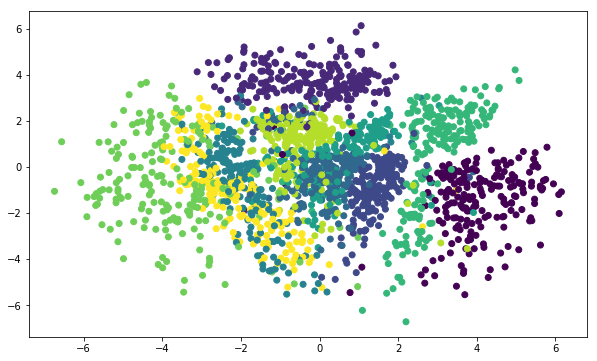

In [31]:
pylab.figure(figsize = (10, 6))
pylab.scatter(subcoords[:, 0], subcoords[:, 1], c = train_labels[:2000])

In [43]:
graph = tf.Graph()
with graph.as_default():
    z2 = tf.placeholder(tf.float32, [None, 2])
    x  = input_layer = tf.placeholder(tf.float32, [None, 28 * 28])
    efc1 = tf.layers.dense(inputs=input_layer, units=128, activation=tf.nn.relu)
    efc2 = tf.layers.dense(inputs=efc1, units=64, activation=tf.nn.relu)
    efc3 = tf.layers.dense(inputs=efc2, units=32, activation=tf.nn.relu)
    m = tf.layers.dense(inputs=efc3, units=Z, activation=None)
    sigma = tf.layers.dense(inputs=efc3, units=Z, activation=None)
    
    eps = tf.random_normal(tf.shape(m), 0, 1, dtype=tf.float32)
    z = m + tf.sqrt(tf.exp(sigma)) * eps
    
    dfc1 = tf.layers.dense(inputs=z2, units=32, activation=tf.nn.relu)
    print(dfc1)
    dfc2 = tf.layers.dense(inputs=dfc1, units=64, activation=tf.nn.relu)
    dfc3 = tf.layers.dense(inputs=dfc2, units=28*28, activation=None)
    print(dfc3)
    y = tf.sigmoid(dfc3)


Tensor("dense_6/Relu:0", shape=(?, 32), dtype=float32)
Tensor("dense_8/BiasAdd:0", shape=(?, 784), dtype=float32)


In [44]:
session = tf.InteractiveSession(graph=graph)
#session.run(tf.global_variables_initializer())
saver = tf.train.Saver()
latest_checkpoint = tf.train.latest_checkpoint("./tmp/mnist_vae_fixed6")
print(latest_checkpoint)
saver.restore(session, latest_checkpoint)

./tmp/mnist_vae_fixed6/model.ckpt-913999
INFO:tensorflow:Restoring parameters from ./tmp/mnist_vae_fixed6/model.ckpt-913999


In [77]:
coords = []
for i in range(11):
    for j in range(11):
        coords.append([-3+i*0.6, -3+j*0.6])

In [78]:
x = session.run([y], feed_dict={z2: coords})[0]

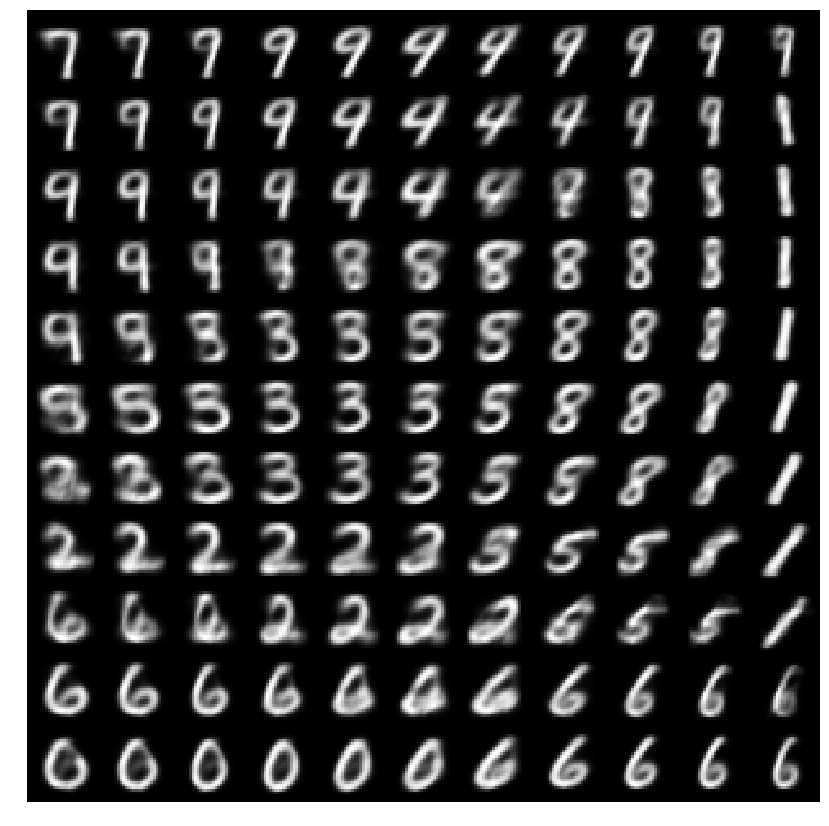

In [79]:
fig = plt.figure(figsize=(11, 11))
for i, image in enumerate(x.reshape(-1, 28, 28), start=1):
    ax = fig.add_subplot(11, 11, i)
    ax.imshow(image, aspect="auto", cmap="gray")
    ax.axis("off")
fig.subplots_adjust(hspace=0, wspace=0, left=0, bottom=0, right=1, top=1)
#fig.savefig("grid.jpg")